In [8]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from scipy.stats import chisquare, mannwhitneyu
from statsmodels.api import qqplot

In [2]:
import warnings
warnings.simplefilter("ignore")

**Задание 1**

Проанализировать набор данных и ответить на следующие вопросы:

1) Какой % наблюдений выходит за 05 и 95 перцентиль?

2) Какому закону распределения отвечают данные? На основе чего вы так решили?

[Ссылка на данные](https://drive.google.com/file/d/1fc8BGSjDiwbZW6rcr3mMSwAjU2T_BpGW/view?usp=sharing)

Описание данных:

* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 


*Вместе с ответом на задание приложить код*

In [3]:
df = pd.read_csv('test_1_1.csv', sep=';', index_col=0)
df.head()

,metrics
1,1
2,1
3,4
4,1
5,1


In [4]:
df.shape[0]

306839

In [5]:
df.nunique()

metrics    338
dtype: int64

In [6]:
df['metrics'].value_counts()

1      132041
2       38880
3       21902
4       14785
5       10608
        ...  
357         1
285         1
355         1
354         1
367         1
Name: metrics, Length: 338, dtype: int64

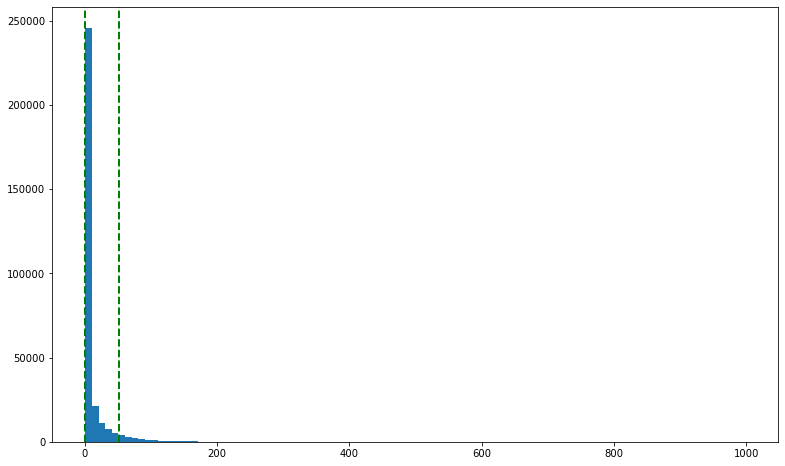

In [26]:
plt.figure(figsize=(13, 8))
plt.hist(df['metrics'], bins=100)
beta_q5, beta_q95 = np.percentile(df['metrics'], [5, 95])
plt.axvline(x=beta_q5, linewidth=2, color='g',linestyle='--')
plt.axvline(x=beta_q95, linewidth=2, color='g',linestyle='--')
plt.show()

In [39]:
(df[df['metrics'] > beta_q5]['metrics'].count() / df.shape[0]) * 100

56.9673346608482


In [41]:
(df[df['metrics'] > beta_q95]['metrics'].count() / df.shape[0]) * 100

4.987306046493438

~57% наблюдений выходят за 05 перцентиль (это связано с тем, что почти половина значений - это 1 просмотр)

~5% наблюдений выходят за 95 перцентиль (что обяснимо, т.к. 5% выборки находятся вне остальных 95%)

Если бы данные были не дискретными, а непрерывными, то мы получили бы ровно 95 и 5%.

Для дальнейшего анализа очистим данные от выбросов.

In [163]:
data = df[(df['metrics'] <= beta_q95) & (df['metrics'] > beta_q5)]['metrics']

Power_divergenceResult(statistic=0.42208601755132363, pvalue=1.0)
Power_divergenceResult(statistic=0.07220635809621129, pvalue=1.0)
Power_divergenceResult(statistic=0.1680328838410085, pvalue=1.0)
Power_divergenceResult(statistic=0.06951639714472481, pvalue=1.0)
Power_divergenceResult(statistic=0.28535776472962904, pvalue=1.0)


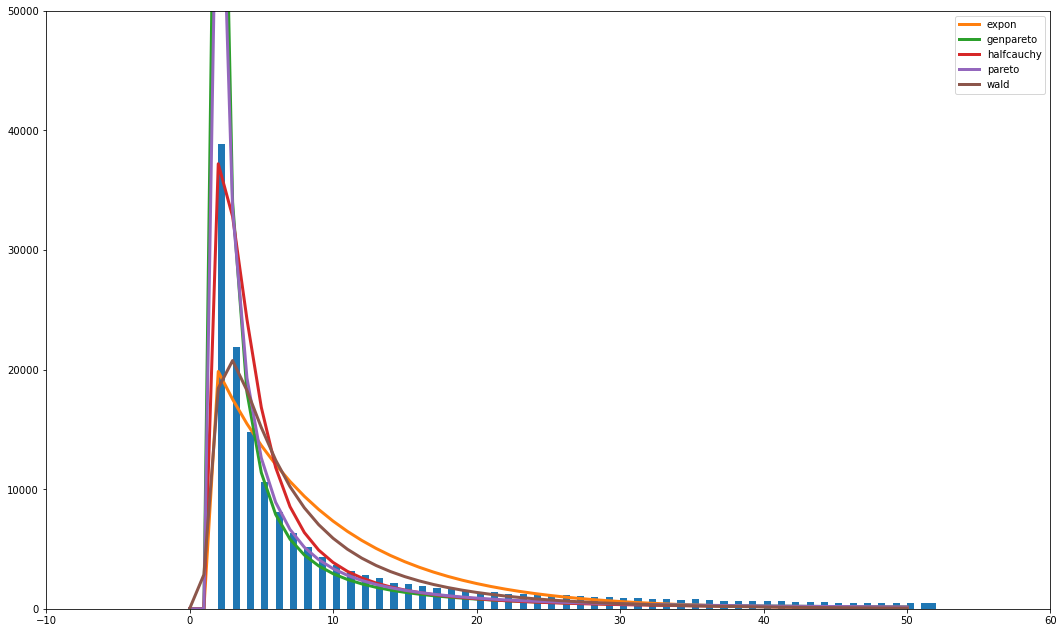

In [300]:
#dist_list = ['expon', 'genexpon', 'genpareto', 'gompertz', 'halfcauchy', 'lomax', 'pareto',] 
dist_list = ['expon', 'halfcauchy', 'pareto', 'wald']
plt.figure(figsize=(18, 11))
plt.hist(data, bins=100)
for d in dist_list:
    dist = getattr(scipy.stats, d)
    param = dist.fit(data)
    x = np.arange(len(data.value_counts()))
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * len(data)
    print(chisquare(data.value_counts()[:-3] / np.sum(data.value_counts()[:-3]), pdf_fitted[3:] / np.sum(pdf_fitted[3:])))
    plt.plot(pdf_fitted,linewidth=3, label=d)
plt.xlim(-10,60)
plt.ylim(0,50000)
plt.legend(loc='upper right')
plt.show()

Из всех представленных в scipy.stats distributions я выбрала распределения, наиболее подходящие под данные.

Я пробовала подобирать еще и среди дискретных распределений (например, распределение Пуассона - аналог экспоненциального). Но даже визуально получается не очень подходяще.

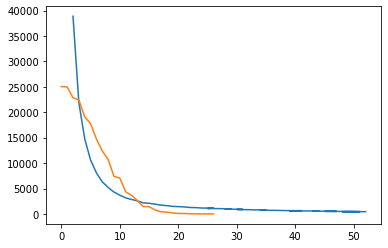

In [145]:
rvs_fitted = sp.stats.poisson.rvs(np.mean(data), 3, size=200000)
plt.plot(data.value_counts())
plt.plot(pd.Series(rvs_fitted).value_counts().values)
plt.show()

Power_divergenceResult(statistic=0.06951639714472481, pvalue=1.0)


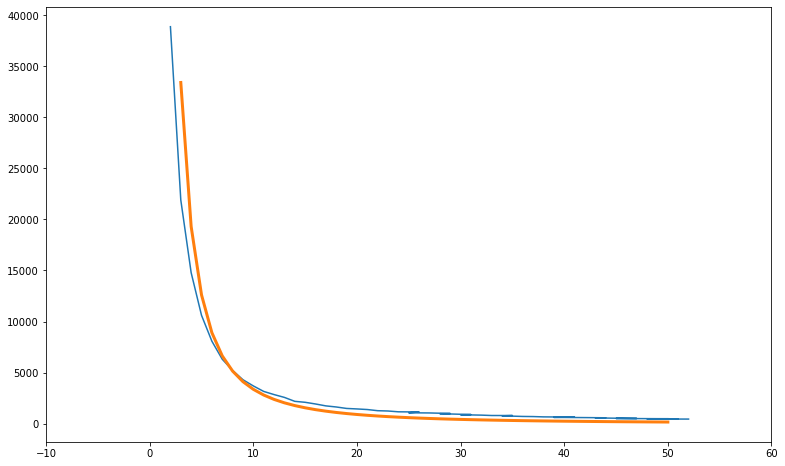

In [184]:
plt.figure(figsize=(13, 8))
plt.plot(data.value_counts())
dist = sp.stats.pareto
param = dist.fit(data)
x = np.arange(len(data.value_counts()))
pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * len(data)
print(chisquare(data.value_counts()[:-3].values / np.sum(data.value_counts()[:-3]), pdf_fitted[3:] / np.sum(pdf_fitted[3:])))
plt.plot(x[3:], pdf_fitted[3:],linewidth=3)
plt.xlim(-10,60)
#plt.ylim(0,50000)
plt.show()

Лучше всего (если смотреть на statistic в критерии) подошло Pareto распределение.

Если оно подходит, то ниже должна получиться прямая линия (что визуально и наблюдается).

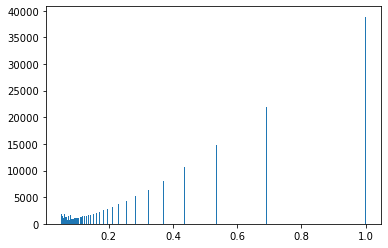

In [185]:
b, loc, scale = param[-3], param[-2], param[-1]
plt.hist(((data - loc) / scale) ** (-b), bins=300)
plt.show()

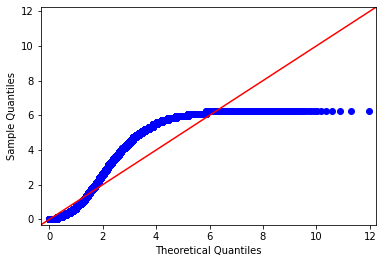

In [182]:
fig = qqplot(data, sp.stats.expon, line='45', fit=True)

Quantile-quantile graph показывает, как квантили экспериментального распределения пересекаются с квантилями теоретического распределения. Для первой половины квантилей распределение походит достаточно хорошо. 

Но хвост экспериментального распределения совершенно не описывается подобранным распределением, так как у распределения длинный хвост и большая дисперсия. В хвосте намного меньше данных, что черевато большой концентрацией выбросов. Но первая половина данных экспоненциальным распределением описывается хорошо.

Исходя из природы данных, можно сказать, что они действительно близки к экспоненциальному распределению. Наиболее вероятно встретить человека, который один раз кликнет на статью/запись и больше никогда к ней не вернется, меньшее количество человек заинтересует запись и они ее перечитают, еще меньшее количество будут к ней возвращаться на регулярной основе.

**Задание 2**

Определить, можно сравнить две представленные выборки t критерием Стьюдента? 

Если нельзя сравнивать t-критерием, то что будем использовать и почему?

Ответ аргументировать и описать 

[Ссылка на данные](https://drive.google.com/file/d/1blvC6TEBWghhVMexjOdoGEjzhZZh3wSy/view?usp=sharing)

Описание данных: 

* variant -- вариация в А/Б тесте (либо группа А -- например, сайт без изменений. Либо группа Б -- сайт с изменениями)
* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 

*Вместе с ответом на задание приложить код*

In [187]:
df2 = pd.read_csv('test_1_2.csv', sep=';', index_col=0)
df2.head()

,variant,metrics
1,A,1
2,B,1
3,A,4
4,B,37
5,B,4


In [188]:
X = df2[df2['variant'] == 'A']['metrics']
Y = df2[df2['variant'] == 'B']['metrics']

In [265]:
X.nunique(), Y.nunique()

(283, 275)

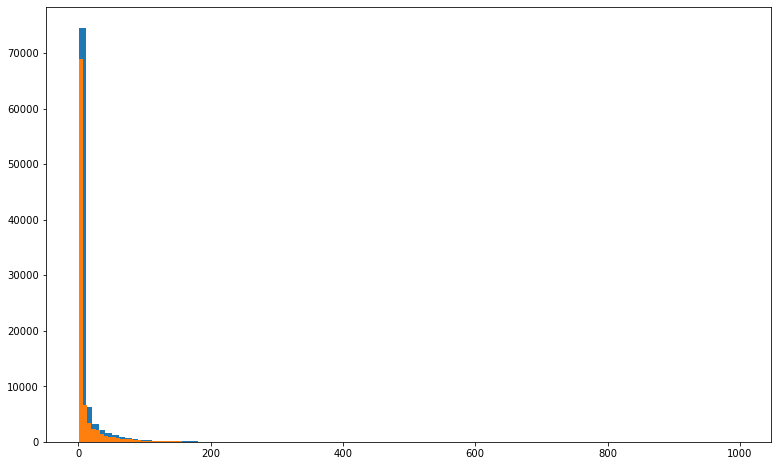

In [370]:
plt.figure(figsize=(13, 8))
plt.hist(X, bins=100)
plt.hist(Y, bins=100)
#plt.xlim(-10, 150)
plt.show()

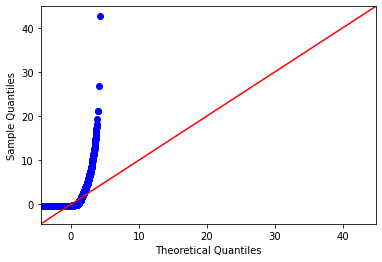

In [232]:
fig = qqplot(X, sp.stats.norm, line='45', fit=True)

Преобразование Кокса-Бокса и логарифмирование для данных не подошло, они не стали нормально-распределенными. По виду qq-graph видно, что данные не распределены нормально.

Сравнивать такие выборки с помощью t-критерия нельзя, так как он предназначен для сравнения выборок, распределенных по нормальному закону, а у нас здесь распределение, похоже на экспоненциальное. 

In [283]:
chisquare(X.value_counts()[:275], Y.value_counts())

Power_divergenceResult(statistic=124.21100864116526, pvalue=0.9999999999999998)

Сравнивать будем с помощью критерия Хи-квадрат (это сделать можно, поскольку размеры выборок примерно одинаковые). Этот критерий можно применять для сравнения 2х экспериментальных распределений. Гипотезу $H_0$ об отсутствии различий принимаем - независимыые выборки однородны. Критерий показывает, что экспериментальные распределения не различаются.

Поскольку у распределения очень большой хвост - большая дисперсия, то один из способов уменьшить дисперисю - убрать выбросы - поэтому можно не учитывать часть крайних данных (всего 8 элементов).

**Задание 3**

Дано две выборки по А/Б тесту.

Две выборки несбалансированные - кол-во пользователей в каждой группе разные.

Метрика, которую меряем в эксперименте (и которую используем для определения группы, которая лучше себя показала) - кол-во просмотренных страниц на пользователя 

Как вы будете принимать решение, какая группа лучше А или Б, и какие статистические методы (критерии) вы будете использовать, какие преобразования к данным применять? P.S. Вам может помочь лекция Виталия Черемисинова, где он рассказывал про А/Б тесты

[Ссылка на данные](https://drive.google.com/file/d/1_g7Dw7-8QzTS47D6GNKMb0FzqMAWBDba/view?usp=sharing)

Описание данных: 

* variant -- вариация в А/Б тесте (либо группа А -- например, сайт без изменений. Либо группа Б -- сайт с изменениями)
* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 


*Вместе с ответом на задание приложить код*

Используем метод доверительных интервалов на основе бутстрапа.

Логарифмирование, преобазование Бокса-Кокса не подошли для нормализации данных.

In [146]:
df3 = pd.read_csv('test_1_3.csv', sep=';', index_col=0)
df3.head()

,variant,metrics
1,A,1
2,A,4
3,A,15
4,A,1
5,A,10


In [147]:
X3 = df3[df3['variant'] == 'A']['metrics'].values
Y3 = df3[df3['variant'] == 'D']['metrics'].values
len(np.unique(X3)), len(np.unique(Y3))

(283, 182)

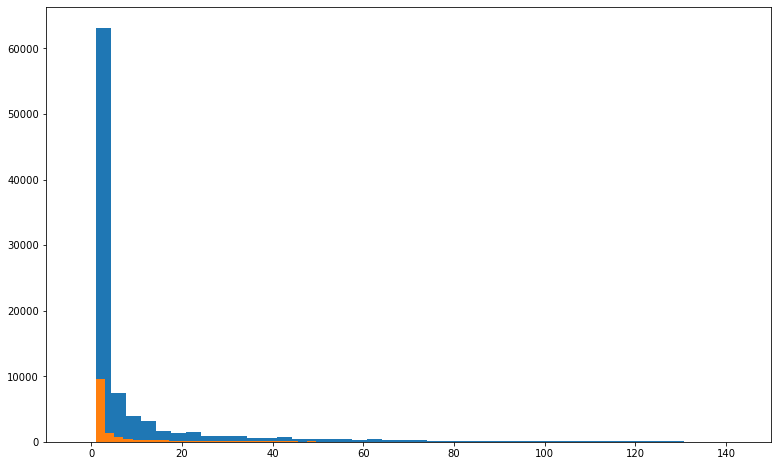

In [148]:
plt.figure(figsize=(13, 8))
plt.hist(X3, bins=300)
plt.hist(Y3, bins=200)
plt.xlim(-10, 150)
plt.show()

In [149]:
mannwhitneyu(X3, Y3)

MannwhitneyuResult(statistic=710155085.5, pvalue=0.11455772745929804)

Критерий Манна-Уитни проверяет насколько часто [X > Y] = [X < Y] (не учитывает величины наблюдений, а учитывает только их ранги).

Значения метрик отличаются незначимо (нет оснований отвергнуть гипотезу) - совпадение медиан в выборках не случайно. При этом критерий Манна-Уитни не учитывает различия в количестве наблюдений, что хорошо, т.к. выборки у нас не сбалансированные.

Медианы не отличаются - в соответствии с этим критерием никакая из групп не лучше, различия статистически не значимы.

Попробуем метод бутстрапа: сформируем несколько раз выборку с возвращением и посчитаем для каждой выборки метрику.

In [153]:
def bootstrap(data, n):
    new_data = []
    for i in range(n):
        ind = np.array(np.random.randint(len(data), size=len(data)))
        new_data.append(np.mean(data[ind]))
    return new_data

In [154]:
new_X3 = bootstrap(X3, 1000)
new_Y3 = bootstrap(Y3, 1000)

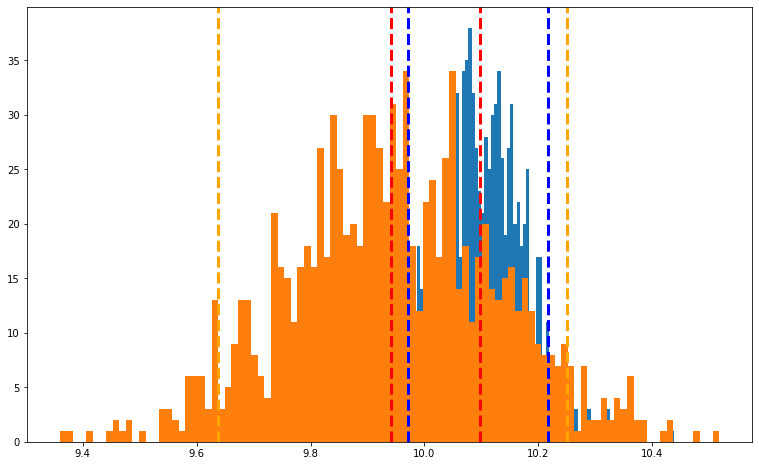

In [234]:
plt.figure(figsize=(13, 8))
plt.hist(new_X3, bins=100)
alpha_q5, alhpa_q95, alpha = np.percentile(new_X3, [5, 95, 50])
plt.axvline(x=alpha, linewidth=3, color='r',linestyle='--')
plt.axvline(x=alpha_q5, linewidth=3, color='b',linestyle='--')
plt.axvline(x=alhpa_q95, linewidth=3, color='b',linestyle='--')
plt.hist(new_Y3, bins=100)
alpha_q5, alhpa_q95, alpha = np.percentile(new_Y3, [5, 95, 50])
plt.axvline(x=alpha, linewidth=3, color='r',linestyle='--')
plt.axvline(x=alpha_q5, linewidth=3, color='orange',linestyle='--')
plt.axvline(x=alhpa_q95, linewidth=3, color='orange',linestyle='--')
plt.show()

На рисунке изображены соответствующим цветом 5 и 95 квантили.

Посмотрим на 5% доврительный интервал. Доверительный интервал для группы А полностью содержится в интервале для группы Б. 5 и 95 квантили перекрываются.

Наблюдаемые различия в группах А и Б статистически незначимые.

In [273]:
new_stat = np.array(new_X3) - np.array(new_Y3)

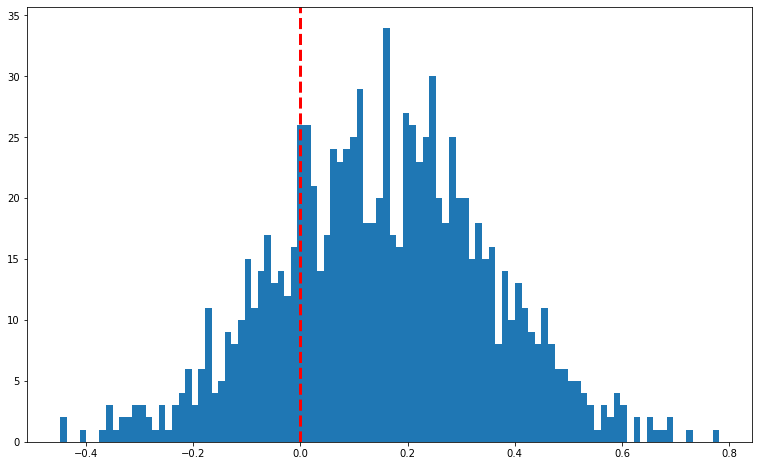

In [214]:
plt.figure(figsize=(13, 8))
plt.hist(list(new_stat), bins=100)
plt.axvline(x=0, linewidth=3, color='r',linestyle='--')
plt.show()

In [274]:
pval_1 = min(sum(new_stat>= 0, new_stat<=0))*2/1000
pval_2 = min((1+sum(new_stat>= 0, new_stat<=0)))*2/(1001)
pval_1, pval_2

(0.002, 0.003996003996003996)

Мы воспользовались непараметрическим критерием на основе бутстрапа. Рассмотрели соответствующую разность между средними 2х групп, полученных с помощью бутстрапа. Далее по формуле из лекции вычислили pvalue (относительно нулевого значения, которое отмечено на гистограмме).

Оба pvalue ниже уровня значимости, и гипотезу об отсутствии различий можно отвергать. Соответственно, метрика для группы A лучше.

Критерий бутстрапа хорошо применять, когда данные не сбалансированные.

**Задание 4**

Есть данные с большой дисперсии у метрики (диспресию метрики можно посчитать для каждой группы). Для их дальнейшего анализа дисперсию необходимо сократить. Как определить, что дисперсия действительно большая? Если она большая, как вы будете ее чистить? Ответ аргументировать и описать.  P.S. Вам может помочь лекция Виталия Черемисинова, где он рассказывал про А/Б тесты

Описание данных: 

* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 

[Ссылка на данные](https://drive.google.com/file/d/1fc8BGSjDiwbZW6rcr3mMSwAjU2T_BpGW/view?usp=sharing)

*Вместе с ответом на задание приложить код*

In [194]:
df4 = pd.read_csv('test_1_1.csv', sep=';', index_col=0)
df4.head()

,metrics
1,1
2,1
3,4
4,1
5,1


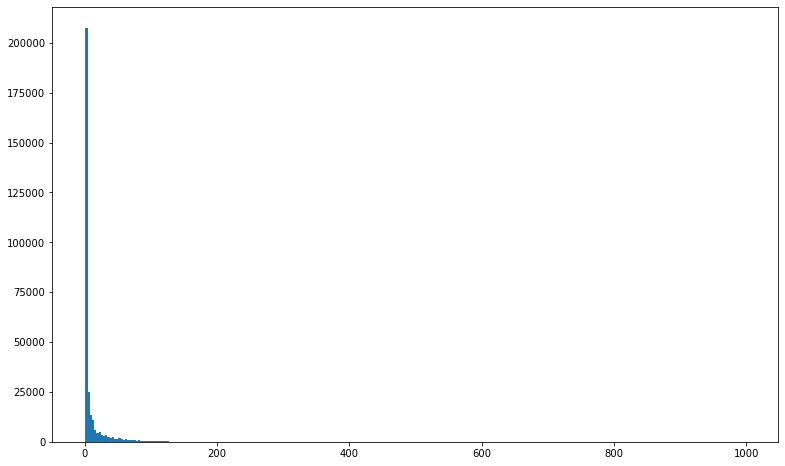

In [195]:
plt.figure(figsize=(13, 8))
plt.hist(df4['metrics'], bins=300)
plt.show()

По длинному хвосту распределния видно, что дисперсия достаточно большая.

Также можно оценить дисперсию функционала (взяла среднее значение) с помощью бутстрапа (формула с семинара).

$D_F(T_n) \approx v_{boot} = \frac{1}{B - 1} \sum\limits_{b=1}^B \left(T_b^* - \bar{T}^* \right)^2$

In [200]:
def bootstrap_std(data, n):
# функция возвращает оценку дисперсии среднего и доверительный интервал для среднего
    T = np.mean(data)
    new_data = []
    for i in range(n):
        ind = np.array(np.random.randint(len(data), size=len(data)))
        new_data.append(np.mean(data[ind]))
    return np.linalg.norm(new_data - T), (np.percentile(new_data, 2.5), np.percentile(new_data, 97.5))

In [201]:
bootstrap_std(df4['metrics'].values, 1000)

(1.2763835012374727, (10.066558195014323, 10.228664218042686))

In [202]:
alpha_q5, alhpa_q95 = np.percentile(df4['metrics'], [5, 95])
data4 = df4[(df4['metrics'] <= alhpa_q95) & (df4['metrics'] > alpha_q5)]['metrics']
bootstrap_std(data4.values, 1000)

(0.9155181327472778, (9.979602338631306, 10.094305464121133))

In [235]:
bootstrap_std(np.log(data4.values), 1000)

(0.0794284498586122, (1.7887787747039923, 1.798586515236433))

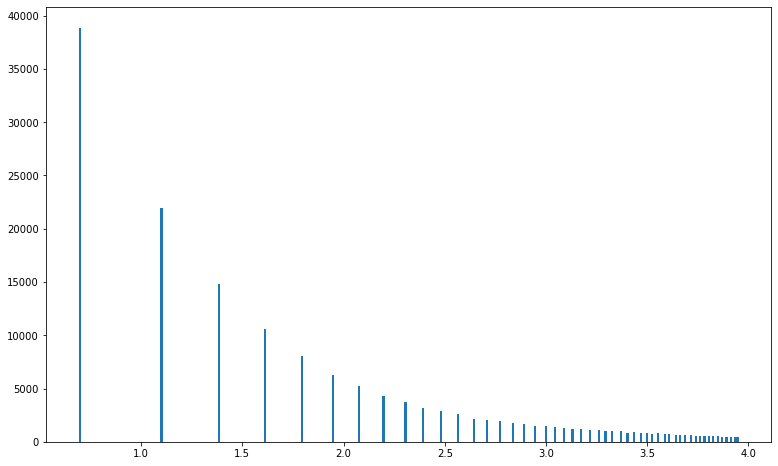

In [236]:
plt.figure(figsize=(13, 8))
plt.hist(np.log(data4.values), bins=300)
plt.show()

Дисперсия функционала действительно большая.

Чтобы уменьшить дисперсию:
- можно поробовать убрать выбросы и немного стабилизировать выборку; мы можем это сделать, так как не сильно повлияем на распределение, если уберем единицы - самое популярное значение, и потому что слишком большое количество кликов - это уже странно (возможно это вообще бот)
- можно применить трансформацию (логарифм, преобразование Бокса-Кокса) - это помогает уменьшить разброс данных 

Методы выше действительно помогли и  дисперсия уменьшилась.

Попробуем реализовать децильный метод сокращения дисперсии.
- отсортировать всю совокупность, разделить на 10 равных частей (децилей)
- посчитать метрику внутри каждого дециля (внутри дециля дисперсия будет меньше)

In [203]:
decile = np.percentile(data4, np.arange(0, 100, 10))
decile

array([ 2.,  2.,  2.,  3.,  4.,  5.,  7., 10., 16., 28.])

Децильный метод не сработает, справа все равно останется большая дисперсия (судя по границам децилей).

Попробуем реализовать стратификацию. Этот метод активно применяется для уменьшения дисперсии, не искажая данные. Этот метод похож на децильный. Мы сортируем данные, последовательно разделяем на бакеты одинакового размера, затем из каждого бакета наугад выбираем элемент.

In [256]:
data4.shape

(159495,)

In [245]:
def stratification(data, n_samples):
    new_data = sorted(data)
    return_data = []
    for i in range(0, len(data), n_samples):
        return_data.append(np.random.choice(new_data[i:i+n_samples]))
    return return_data

In [268]:
data4s = stratification(data4, 100)

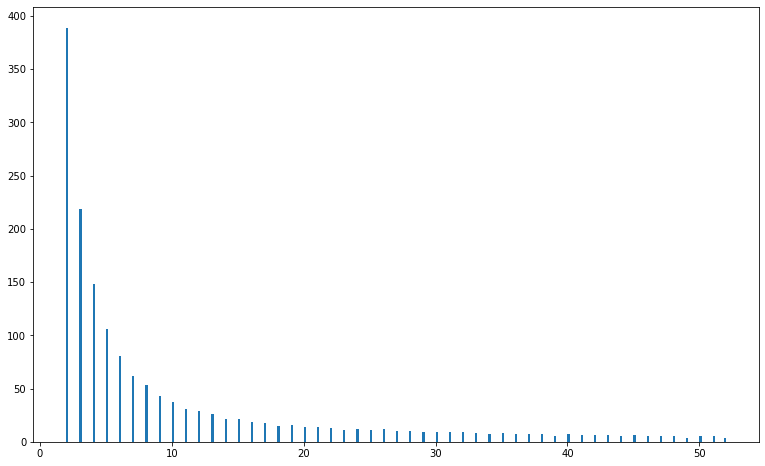

In [269]:
plt.figure(figsize=(13, 8))
plt.hist(data4s, bins=300)
plt.show()

По рисунку видно, что дисперсия уменьшилась - хвост стал не таким длинным. При этом мы сохранили структуру данных, используя стратификацию.

**Задание 5**

Есть эксперимент с поисковыми подсказками. Вы хотим узнать, как изменился CTR в каждой группе эксперимента.

**Данные**

- id - уникальный идентификатор пользователя
- action -
- view - кол-во просмотров на одну сессию
- variant - вариант a/b теста, где 0 - это версия "A", 1 -  версия "B".

**Задача**

- сформировать метрику для оценки эксперимента
- подобрать критерий под особенности данных
- сделать вывод о значимости эффекта

**Данные** 

[Ссылка на данные](https://www.dropbox.com/s/fdki267uilkfq7l/task5.csv)

CTR = количество кликов / количество показов

Для сокращения дисперсии было бы хорошо применить CUPED, но у нас нет значения метрики до/после эксперимента.

In [218]:
df5 = pd.read_csv('task5.csv')
df5.head()

,id,variant,view,action
0,88258,A,10,2
1,109938,A,3,1
2,117644,A,7,5
3,374080,A,9,9
4,662082,A,1,1


In [219]:
df5.shape[0], df5['id'].nunique()

(8191, 8191)

In [220]:
df5['CTR'] = df5['action'] / df5['view']
df5.head()

,id,variant,view,action,CTR
0,88258,A,10,2,0.200000
1,109938,A,3,1,0.333333
2,117644,A,7,5,0.714286
3,374080,A,9,9,1.000000
4,662082,A,1,1,1.000000


In [221]:
X5 = df5[df5['variant'] == 'A']['CTR']
Y5 = df5[df5['variant'] == 'B']['CTR']
X5.nunique(), Y5.nunique()

(79, 74)

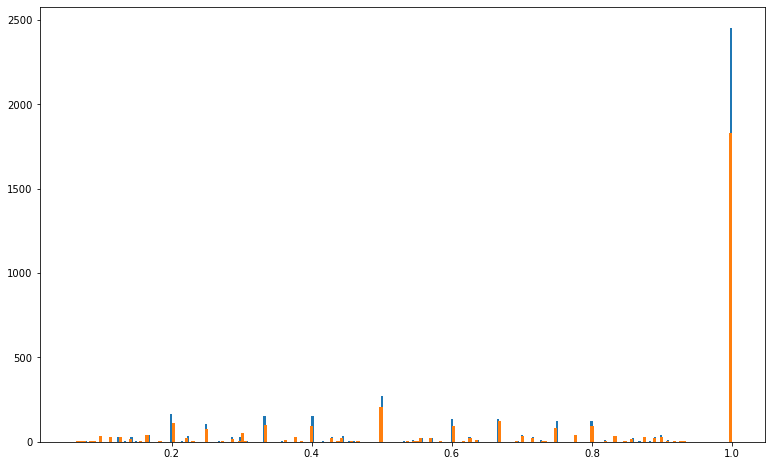

In [222]:
plt.figure(figsize=(13, 8))
plt.hist(X5, bins=300)
plt.hist(Y5, bins=200)
plt.show()

In [223]:
mannwhitneyu(X5, Y5)

MannwhitneyuResult(statistic=8144665.5, pvalue=0.17854643929605546)

In [16]:
len(Y5[Y5 == 1]) / len(X5[X5 == 1]), Y5.nunique() / X5.nunique()

(0.745417515274949, 0.9367088607594937)

In [69]:
np.mean(X5), np.mean(Y5)

(0.7615838991498786, 0.756497644163971)

In [224]:
new_X5 = bootstrap(X5.values, 2000)
new_Y5 = bootstrap(Y5.values, 2000)

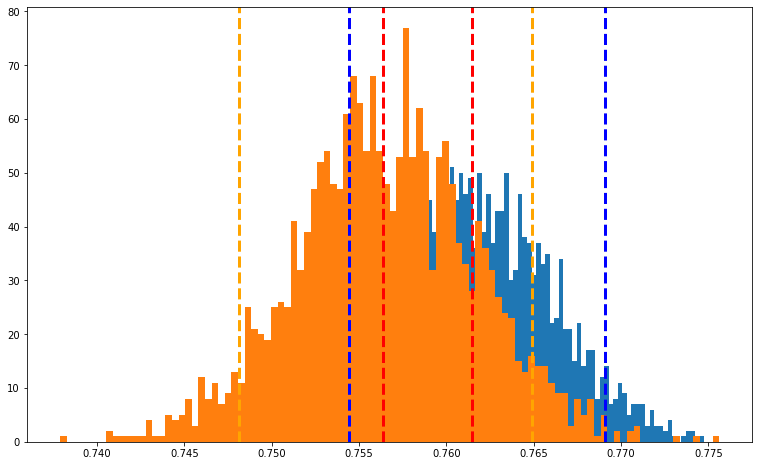

In [271]:
plt.figure(figsize=(13, 8))
plt.hist(new_X5, bins=100)
alpha_q5, alhpa_q95, alpha = np.percentile(new_X5, [5, 95, 50])
plt.axvline(x=alpha, linewidth=3, color='r',linestyle='--')
plt.axvline(x=alpha_q5, linewidth=3, color='b',linestyle='--')
plt.axvline(x=alhpa_q95, linewidth=3, color='b',linestyle='--')
plt.hist(new_Y5, bins=100)
alpha_q5, alhpa_q95, alpha = np.percentile(new_Y5, [5, 95, 50])
plt.axvline(x=alpha, linewidth=3, color='r',linestyle='--')
plt.axvline(x=alpha_q5, linewidth=3, color='orange',linestyle='--')
plt.axvline(x=alhpa_q95, linewidth=3, color='orange',linestyle='--')
plt.show()

Проведем анализ аналогично 3-му заданию. Воспользуемся технологией бутстрапа. Сгенерируем несколько подвыборок с возвращением и посчитаем на них метрику, а потом посмотрим на 5% доврительный интервал.
Бутстрап хорошо использовать, когда истинное распределение данных неизвестно. Данные из-за бутстрапа не нормализовались, но засчет выбора данных с возвращением они сгруппировались около действительного среднего значения, для которого можно вычислить доверительный интервал.

Тест Манна-Уитни говорит, что различия в средних не значимы, нулевую гипотезу от отсутствии различий принимаем.

Построив доверительные интервалы с помощью бутстрапа, мы видим, что 5 перцентиль одного распредения перекрывается с 95 перцентилем другого распределения - статистически значимой разницы между экспериментами нет.

Значит наблюдаемый эффект статистически незначимый.

In [275]:
new_stat5 = np.array(new_X5) - np.array(new_Y5)

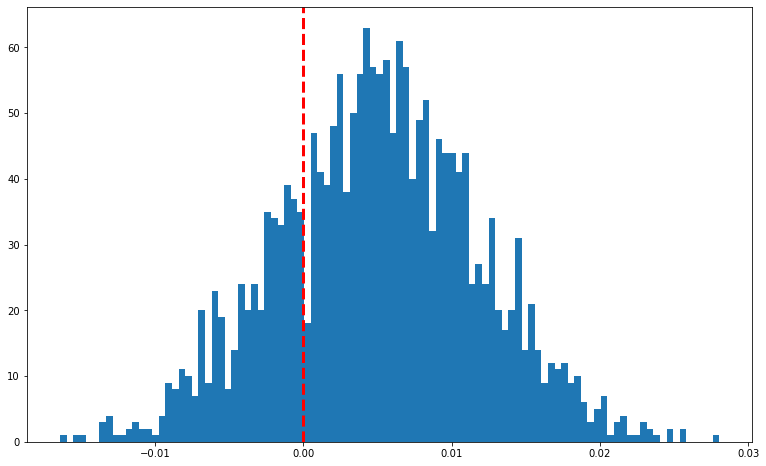

In [228]:
plt.figure(figsize=(13, 8))
plt.hist(list(new_stat5), bins=100)
plt.axvline(x=0, linewidth=3, color='r',linestyle='--')
plt.show()

In [276]:
pval_1 = min(sum(new_stat5>= 0, new_stat5<=0))*2/1000
pval_2 = min((1+sum(new_stat5>= 0, new_stat5<=0)))*2/(1001)
pval_1, pval_2

(0.002, 0.003996003996003996)

Воспользуемся непараметрическим критерием на основе бутстрапа. Оба pvalue ниже уровня значимости, и гипотезу об отсутствии различий можно отвергать. Соответственно, метрика для группы А лучше.